### create data from stock

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping
from keras import Input, saving
from curl_cffi import requests
import os, joblib

SYMBOL = "IFX.DE"
HISTORY = "10y"

class Stock_Model:
    CLASSES = ["Bull", "Bear"]
    def __init__(self, stock, period, interval="1d", win_size=60):
        self._stock = stock
        self._period = period
        self._interval = interval
        self._window_size = win_size # default 60 days
        self._model_name = f"{self._stock}_{self._period}_{self._interval}_{self._window_size}"
        ### default all features
        self._base_features = np.array([['Open', 'High', 'Low', 'Close', 'Volume', "Dividends", "Stock Splits"]])
        self._stock_data = None
        self._X_train = None
        self._Y_train = None
        self._X_test = None
        self._Y_test = None
        self._data = None
        self._model = None

    @property
    def model_name(self):
        return self._model_name
        
    @property
    def stock_data(self):
        return self._stock_data

    @property
    def test_data(self):
        if self._data is None:
            return None
        return self._data

    @property
    def test_data_num(self):
        if self._data is None:
            return 0
        return len(self._data)
        
    @property
    def features(self):
        if self._features is None:
            return self._base_features
        return self._features

    @property
    def window_size(self):
        return self._window_size

    @window_size.setter
    def window_size(self, ws):
        self._window_size = ws

    ### Step 1. obtain stock data from markt
    def load_stock(self, stock=None, period=None, interval=None):
        ## read stock data from stock markt
        self._stock = stock if stock is not None else self._stock
        self._period = period if period is not None else self._period
        self._interval = interval if interval is not None else self._interval    
        self.session = requests.Session(impersonate="chrome")
        self._stock_data = yf.Ticker(self._stock, session=self.session).history(period=self._period, interval=self._interval)
        self._features = None
        # self._data = self._stock_data ## used for prediction process

    ### Step 2. prepare data for training
    def set_working_data(self, start_feature=0, end_feature=5, remove_cols=["Dividends", "Stock Splits"]):
        self._features = []
        self._features = np.array([self._base_features[0, start_feature:end_feature]])
        ### remove meaningless columns
        self._data = self._stock_data.drop(columns=remove_cols)
        # remove today data
        self._data = self._data[:-1]
        self._normalize_data()
    
    def _normalize_data(self):
        self._scaler = MinMaxScaler(feature_range=(0, 1))
        self._data = self._scaler.fit_transform(self._features)

    def _create_sequences(self):
        if self.test_data_num < self._window_size:
            raise ValueError("Too few number of data")
        X, Y = [], []
        for i in range(self.test_data_num - self._window_size):
            # Input: add all features: Open, High, Low, Close, Volume
            X.append(self._data[i:i+self._window_size, :]) 
            # Output: predict Close price
            Y.append(self._data[i+self._window_size, 3]) 
        return np.array(X), np.array(Y)

    ### Step 3. construct data for training
    def create_train_test_data(self, train_data_percentage=0.7, save=True):
        if self.test_data_num < self._window_size:
            raise ValueError("Too few number of data")
        if train_data_percentage >= 1.0:
            raise ValueError("Percent must less than 1.0")
        X, Y = self._create_sequences()
        split = int(train_data_percentage * len(X))
        self._X_train, self._X_test = X[:split], X[split:]
        self._Y_train, self._Y_test = Y[:split], Y[split:]
        if save:
            np.savez(f"{self._model_name}.npz", x_train=self._X_train, y_train=self._Y_train, x_test=self._X_test, y_test=self._Y_test)
            
    ### Step 4. construct test model
    def create_LSTM_model(self, load_data_file=None):
        if load_data_file is not None:
            if os.path.exists(load_data_file):
                file_name = os.path.splitext(load_data_file)
                self._model_name = file_name[0]
                datasets = np.load(load_data_file)
                self._X_train, self._Y_train = datasets["x_train"], datasets["y_train"]
                self._X_test, self._Y_test = datasets["x_test"], datasets["y_test"]
            else:
                raise ValueError("The load data file is not found!")

        input_layer = Input(shape=(self._X_train.shape[1], self._X_train.shape[2]))
        self._model = Sequential([
            input_layer,
            LSTM(64, return_sequences=True),  # 输入维度为 (窗口大小, 特征数)
            Dropout(0.3),
            LSTM(32, return_sequences=False),
            Dropout(0.2),
            Dense(1)
        ])
        '''self._model = Sequential()
        self._model.add(Input(shape=(self._X_train.shape[1], self._X_train.shape[2])))
        self._model.add(LSTM(64, return_sequences=True, input_shape=(self._X_train.shape[1], self._X_train.shape[2])))
        self._model.add(Dropout(0.3))
        self._model.add(LSTM(32, return_sequences=False))
        self._model.add(Dropout(0.2))
        self._model.add(Dense(1))'''

    ### Step 5. compile model for training
    def compile_model(self, optim='adam', loss='mse'):
        self._model.compile(optimizer=optim, loss=loss)

    ### Step 6. start training
    def train_model(self, early_stop=True, monitor="loss", patience=10, epochs=100, batch_size=32):
        callback=[]
        if early_stop:
            cb_early_stop = EarlyStopping(monitor=monitor, patience=patience)
            callback.append(cb_early_stop)
        self._history = self._model.fit(
            self._X_train, self._Y_train,
            epochs=epochs,
            batch_size=batch_size,
            callbacks=callback,
            verbose=1
        )

    ### Step 7. predict data with the trained model
    def model_predict(self, data=None):
        if self._model is None:
            print("Warning: model is None. It must be created or loaded!")
            return
        if data:
            self._data = data
            self._normalize_data()
            self._Y_predict = self._model.predict(data)
            dummy_matrix = self._invert_normalized_data()
            # 真实值反归一化
            # dummy_matrix[:, 3] = self._Y_test
            self._Y_test_actual = self._scaler.inverse_transform(dummy_matrix)[:, 3]
        else:
            self._Y_predict = self._model.predict(self._X_test)
            dummy_matrix = self._invert_normalized_data()
            # 真实值反归一化
            dummy_matrix[:, 3] = self._Y_test
            self._Y_test_actual = self._scaler.inverse_transform(dummy_matrix)[:, 3]

    def _invert_normalized_data(self):
        # 反归一化需要重建完整的多变量矩阵（仅Close列有值，其他列置0）
        dummy_matrix = np.zeros((len(self._Y_predict), self.features.shape[1]))
        dummy_matrix[:, 3] = self._Y_predict.flatten()  # 第4列是Close
        self._Y_pred_actual = self._scaler.inverse_transform(dummy_matrix)[:, 3]
        return dummy_matrix

    ### Step 8. show result
    def visual_result(self):
        plt.figure(figsize=(12, 6))
        plt.plot(self._Y_test_actual, label='True Close Price')
        plt.plot(self._Y_pred_actual, label='Predicted Close Price', alpha=0.7)
        plt.title('Multivariate LSTM Stock Price Prediction')
        plt.xlabel('Time')
        plt.ylabel('Price')
        plt.legend()
        plt.show()

    ### Step 9. save training result
    def save_training_result(self):
        result_y_test = np.array(self._Y_test_actual).reshape(-1, 1)
        result_y_test_pred = self._Y_pred_actual
        print(result_y_test, result_y_test_pred)
        result = np.concatenate(result_y_test, result_y_test_pred, axis=1)
        print(result.shapepe)
        result = pd.DataFrame(result, columns=['real price', 'predicted price'])
        result.to_csv(f"result_{self._model_name}.csv")

    ### Step 10. save model to local dist
    def save_model(self):
        # joblib.dump(self._model, f"{self._model_name}.m")
        self._model.save(self._model_name, overwrite=True)

    ### Step 4(1 - not compile) or 5(1 - to compile)
    def load_model(self, compile=True):
        '''
        load_model
        after load model, process step 5 or 6 depending if model is compiled.
        '''
        # self._model = joblib.load(self._model_name)
        self._model = saving.load_model(self._model_name, compile=compile)

In [2]:
stock_daten = Stock_Model(SYMBOL, HISTORY)
stock_daten.load_stock()
stock_daten.features.shape

$IFX.DE: possibly delisted; no price data found  (period=10y)


(1, 7)

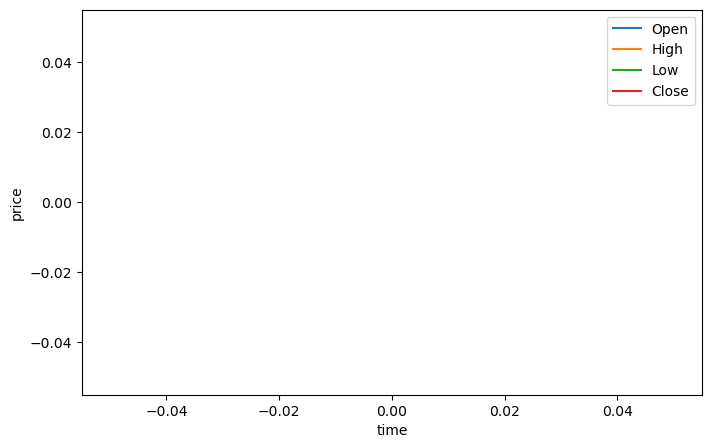

In [3]:
%matplotlib inline
from matplotlib import pyplot as plt
fig1 = plt.figure(figsize=(8, 5))
plt.plot(stock_daten.stock_data[stock_daten.features[0][0]], label=stock_daten.features[0][0])
plt.plot(stock_daten.stock_data[stock_daten.features[0][1]], label=stock_daten.features[0][1])
plt.plot(stock_daten.stock_data[stock_daten.features[0][2]], label=stock_daten.features[0][2])
plt.plot(stock_daten.stock_data[stock_daten.features[0][3]], label=stock_daten.features[0][3])
#plt.xlim('2023.01.01', '2023.12.31')
plt.xlabel('time')
plt.ylabel('price')
plt.legend()
plt.show()

In [4]:
stock_daten.set_working_data()
print(stock_daten.test_data)
print(stock_daten.test_data.shape)
print(stock_daten.features.shape)

KeyError: "['Dividends', 'Stock Splits'] not found in axis"

### check loaded data

#### construct datasets

In [68]:
stock_daten.create_train_test_data()

In [69]:
print(stock_daten._X_train.shape, stock_daten._Y_train.shape)
print(stock_daten._Y_train)
print(stock_daten._X_test.shape, stock_daten._Y_test.shape)

(1737, 60, 5) (1737,)
[0.03968594 0.03058413 0.02108895 ... 0.58426425 0.55648598 0.53127186]
(745, 60, 5) (745,)


In [70]:
stock_daten.create_LSTM_model()

C:\Users\Peilian.Yuan.SYKAM\AppData\Local\anaconda3\envs\tf\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [71]:
stock_daten.compile_model()

In [72]:
stock_daten.train_model()

Epoch 1/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0602
Epoch 2/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0045
Epoch 3/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0038
Epoch 4/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0032
Epoch 5/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0031
Epoch 6/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0031
Epoch 7/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0033
Epoch 8/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0028
Epoch 9/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0027
Epoch 10/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0028
Epoch 11/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0032
Epoch 12/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0027
Epoch 13/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0023
Epoch 14/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0025
Epoch 15/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - lo

In [74]:
stock_daten.model_predict()

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


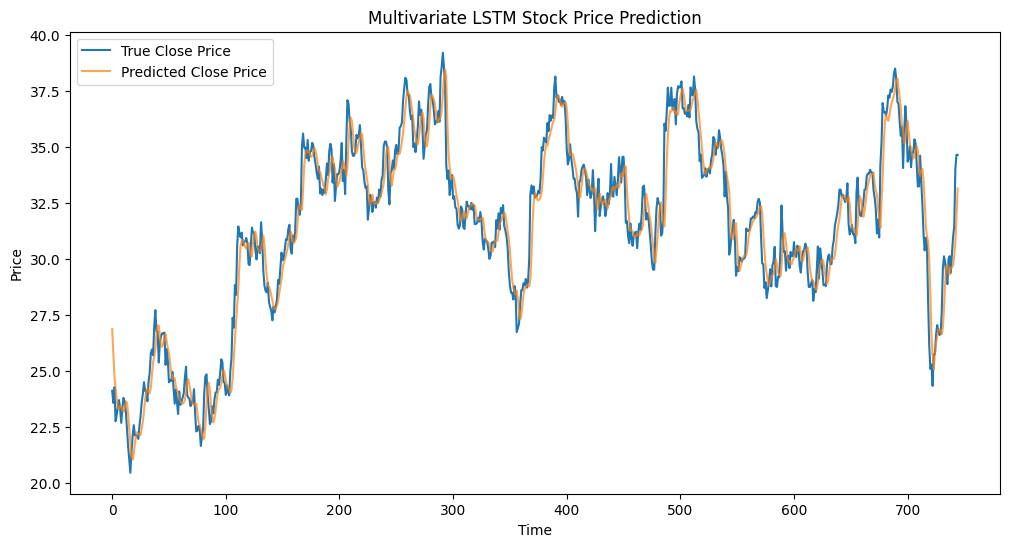

In [75]:
stock_daten.visual_result()

In [77]:
from keras.metrics import Accuracy
print(stock_daten._Y_pred_actual.shape, stock_daten._Y_test_actual.shape)
#acc = Accuracy(stock_daten._Y_pred_actual, stock_daten._Y_test_actual)

(745,) (745,)
